# Main CNN model for bat call classification

### **TO RUN THIS FILE**, just press the "restart&execute" button, and when the kernel dies, restart the notebook process, go to the `exit()` cell and execute all cells after that one

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# dont use gpu [for M1/M2 Metal, cause it cant handle [presumably] Dropout Layers too well], comment out if you want to use GPU
tf.config.set_visible_devices([], 'GPU') 
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K 
import gc
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from tensorflow.keras import regularizers
import tensorflow_model_optimization as tfmot
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import json

In [2]:
data = pd.read_pickle('./data/images_df_numerical.pkl')

def split_df_equal_class_distribution(df, batch_size):
    
    df['temp_id'] = range(len(df))
    
    num_batches = int(np.ceil(len(df) / batch_size))
    
    grouped = df.groupby('Species', group_keys=False)
    
    chunks = []
    
    for i in range(num_batches):
        chunk = pd.DataFrame(columns=df.columns)
        for _, group in grouped:
            num_samples = int(batch_size * len(group) / len(df))
            sample_indices = np.random.choice(group['temp_id'], size=num_samples, replace=False)
            chunk = pd.concat([chunk, df[df['temp_id'].isin(sample_indices)]])
        chunk = chunk.drop('temp_id', axis=1)
        chunks.append(chunk)
    
    return chunks

chunk_size = 1000

chunks_with_same_dist = split_df_equal_class_distribution(data, chunk_size)
del data
classes = chunks_with_same_dist[0]["Species"].unique()
x_len = chunks_with_same_dist[0].iloc[0]["data"].size
number_of_classes = classes.size
most_x_in_one_class = chunks_with_same_dist[0]["Species"].value_counts().iloc[0]

In [3]:
# Alleiniges undersampling wird keinen Sinn machen, da wir extrem wenig Datenpunkte overall haben
def resample(resampler) -> tuple[np.array, np.array]:
    # 0.3 as buffer
    array_size = int(most_x_in_one_class * number_of_classes * (len(chunks_with_same_dist) + 0.3))
    X = np.empty((array_size, x_len), dtype=np.uint8)
    y = np.empty((array_size), dtype=np.uint8)

    current_index = 0
    for chunk in chunks_with_same_dist:
        X_batch, y_batch = chunk['data'], chunk['Species']
        X_batch, y_batch = np.stack(X_batch).astype(np.uint8), y_batch.astype(np.uint8)
        X_resampled, y_resampled = resampler.fit_resample(X_batch, y_batch)
        num_samples = X_resampled.shape[0]
        X[current_index:current_index + num_samples] = X_resampled.astype(np.uint8)
        y[current_index:current_index + num_samples] = y_resampled.astype(np.uint8)
        current_index += num_samples

    X.resize((current_index, X.shape[1]))
    y.resize(current_index)
    print(f"{resampler}: ", pd.Series(y, dtype=pd.UInt8Dtype()).value_counts())

    return X, y

# oversampling
smote = SMOTE()
adasyn = ADASYN()

X, y = resample(adasyn)

# Kombination aus over und undersampling
smoteenn = SMOTEENN()
smotettomek = SMOTETomek()

ADASYN():  2    2320
1    2303
4    2270
5    2262
0    2260
3    2253
Name: count, dtype: Int64


In [4]:
%skip
#skips cell (idk when we dont use chunks the validation acc is simply trash?)
data = pd.read_pickle('./data/images_df_numerical.pkl')
classes = data["Species"].unique()
number_of_classes = classes.size

# Alleiniges undersampling wird keinen Sinn machen, da wir extrem wenig Datenpunkte overall haben
def resample(resampler) -> tuple[np.array, np.array]:
    X, y = data['data'], data['Species']
    X, y = np.stack(X).astype(np.uint8), y.astype(np.uint8)
    X_resampled, y_resampled = resampler.fit_resample(X, y)

    print(f"{resampler}: ", pd.Series(y_resampled, dtype=pd.UInt8Dtype()).value_counts())

    return X_resampled, y_resampled

# oversampling
smote = SMOTE()
adasyn = ADASYN()

# Kombination aus over und undersampling
smoteenn = SMOTEENN()
smotettomek = SMOTETomek()

X, y = resample(adasyn)

UsageError: Line magic function `%skip` not found.


In [5]:
image_size = X[0].size
samples = X.size
with open("./data/meta.json","r") as file:  # get metadata for images from file generated from import nb
    image_meta = json.load(file) 
image_shape = (image_meta['h'],image_meta['w'],image_meta['c']) # hwc
print("Image has shape",image_shape)
smallest_float16 = np.finfo(np.float16).tiny
# normalize to 0-1
X = X / 255.
X = X.reshape((-1,) + image_shape)
#X = X.astype(smallest_float16)

Image has shape (65, 100, 3)


In [6]:
with open("X.npy", "wb") as file:
    np.save(file, X)
with open("y.npy", "wb") as file:
    np.save(file, y)

In [7]:
kfold = KFold(n_splits=10, shuffle=True)

tf.keras.utils.set_random_seed(1)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
tf.config.experimental.enable_op_determinism()

In [8]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, min_delta=0.001, start_from_epoch=15, restore_best_weights=True)
epochs = 200
batch_size = 32
dropout_rate = 0.2 # https://www.kaggle.com/code/rafjaa/dealing-with-very-small-datasets interessant bzgl oberfitting
weight_decay_alpha = 0.01

def create_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=image_shape))
    model.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay_alpha)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay_alpha)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay_alpha)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(weight_decay_alpha)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(weight_decay_alpha)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    #model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(weight_decay_alpha)))
    #model.add(tf.keras.layers.BatchNormalization())
    #model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(number_of_classes, activation='softmax'))

    return model

In [9]:
def fit_model(model, X_train, y_train, worker=8):
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        workers=worker, # workers are number of cores
        callbacks=[early_stopping, tfmot.sparsity.keras.UpdatePruningStep()],
        validation_split=0.2,
        verbose=1)

    return history

In [10]:
# use this when using the saved X&y [also need to run the couple cells above for everything needed]
#with open("X.npy", "rb") as file:
#    X = np.load(file)
#with open("y.npy", "rb") as file:
#    y = np.load(file)

In [11]:
end_step = np.ceil(X.shape[0] / batch_size).astype(np.int32) * epochs

pruning_params = {
    # In this example, you start the model with 50% sparsity (50% zeros in weights) and end with 80% sparsity.
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                                final_sparsity=0.80,
                                                                begin_step=0,
                                                                end_step=end_step)}

model = create_model()
model = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

In [ ]:
#del X, y
#X, y = None, None
#gc.collect()

In [ ]:
# for confusion_matrix
true_labels = list()
pred_labels = list()
train_accuracies = list()
val_accuracies = list()
train_losses = list()
val_losses = list()

#X = np.load("X.npy", mmap_mode="r+")
#y = np.load("y.npy", mmap_mode="r+")
for train_indezes, test_indezes in kfold.split(X, y):
    K.clear_session()
    X_train, y_train = tf.convert_to_tensor(X[train_indezes]), tf.convert_to_tensor(y[train_indezes])
    X_test, y_test = tf.convert_to_tensor(X[train_indezes]), tf.convert_to_tensor(y[test_indezes])
    model.compile(optimizer=Adam(0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    history = fit_model(model, X_train, y_train)

    # for confusion matrix
    predictions = np.argmax(model.predict(X_test), axis=-1)
    true_labels.extend(y_test)
    pred_labels.extend(predictions)

    # for accuracy curves
    train_accuracies.extend(history.history['accuracy'])
    val_accuracies.extend(history.history['val_accuracy'])

    # for loss curves
    train_losses.extend(history.history['loss'])
    val_losses.extend(history.history['val_loss'])

Epoch 1/200
308/308 [==============================] - 13s 34ms/step - loss: 5.8970 - accuracy: 0.3964 - val_loss: 3.8838 - val_accuracy: 0.2722
Epoch 2/200
308/308 [==============================] - 11s 36ms/step - loss: 2.5935 - accuracy: 0.5995 - val_loss: 2.6026 - val_accuracy: 0.4104
Epoch 3/200
308/308 [==============================] - 12s 38ms/step - loss: 1.8544 - accuracy: 0.6941 - val_loss: 2.8092 - val_accuracy: 0.3572
Epoch 4/200
308/308 [==============================] - 12s 39ms/step - loss: 1.5374 - accuracy: 0.7419 - val_loss: 1.5772 - val_accuracy: 0.6875
Epoch 5/200
308/308 [==============================] - 11s 37ms/step - loss: 1.3877 - accuracy: 0.7721 - val_loss: 1.8612 - val_accuracy: 0.6128
Epoch 6/200
308/308 [==============================] - 11s 36ms/step - loss: 1.3493 - accuracy: 0.7865 - val_loss: 1.8322 - val_accuracy: 0.6294
Epoch 7/200
308/308 [==============================] - 11s 35ms/step - loss: 1.3262 - accuracy: 0.7935 - val_loss: 1.6783 - val_ac

In [26]:
a = model.predict(X_test)

385/385 [==============================] - 4s 9ms/step


In [39]:
print(len(X_test),X_test.shape)
print(len(y_test),y_test.shape)
print(a.shape)


12302 (12302, 65, 100, 3)
1366 (1366,)


In [21]:
print(len(true_labels),len(pred_labels))
confusion_matrix = confusion_matrix(true_labels, pred_labels)
fig, ax = plt.subplots(figsize=(8, 6))
cm_display = ConfusionMatrixDisplay(confusion_matrix, display_labels=classes)
cm_display.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

13668 123012


ValueError: Found input variables with inconsistent numbers of samples: [13668, 123012]

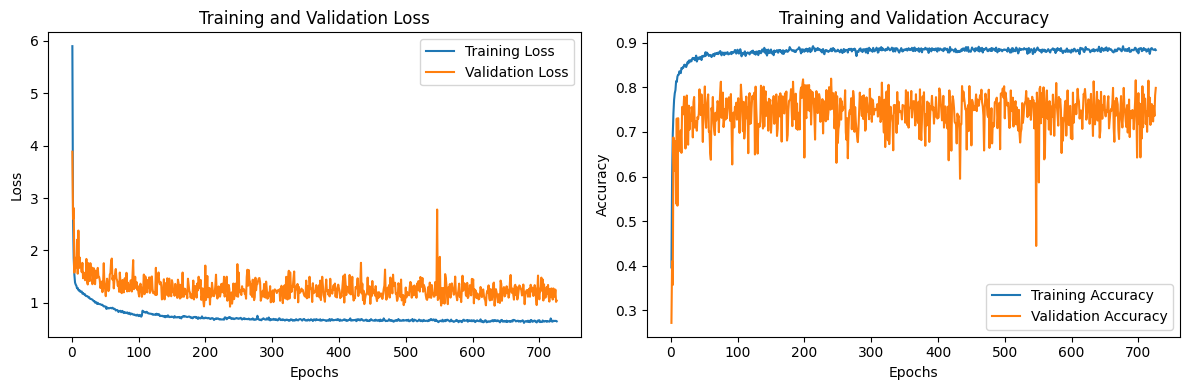

In [22]:
# Plotting the training and validation curves
epochs = len(train_losses)
plt.figure(figsize=(12, 4))

# Plotting loss curves
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig("./cnn_files/loss_and_accuraccy.png")
plt.show()